# 1. Import Libraries

In [167]:
!pip install xgboost

In [196]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta 

from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

# 2. Data Wrangling

## 2.1. Users Data

In [3]:
# read in user table
df_user = pd.read_csv('takehome_users.csv', encoding = 'latin1')
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
# check data type and missing values
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


**Note:** Missing data for `last_session_creation_time` and `invited_by_user_id`. Will address the missing data issue before modeling.

In [103]:
# last session creation time is unix timestamp of last login
# convert it to strftime

df_user['last_session_creation_time'] = [datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S') if pd.notnull(x) else np.nan for x in df_user['last_session_creation_time']]
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


In [105]:
# check if missing values are kept
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   object 
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted_user                12000 non-null  int32  
dtypes: float64(1), int32(1), int64(4), object(5)
memory usage: 984.5+ KB


## 2.2. User Engagement Data

**Need to find who are the adopted users from user engagement data.**

"adopted user" is defined as who has logged in on 3 separate days in at least one 7-day period

In [19]:
# read in the user engagement table
df_engage = pd.read_csv('takehome_user_engagement.csv')
df_engage.head(10)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1


`time_stamp` is in ascending order.

In [8]:
# check data types and missing values
df_engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [33]:
# convert time_stamp to datetime
df_engage['time_stamp'] = pd.to_datetime(df_engage['time_stamp'])
df_engage['date'] = df_engage['time_stamp'].dt.date
df_engage.head()

,time_stamp,user_id,visited,date
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


In [34]:
df_engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
 3   date        207917 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.3+ MB


In [18]:
# check what values for visited column
df_engage['visited'].value_counts()

1    207917
Name: visited, dtype: int64

`visited` column is useless.

In [35]:
# let keep only user_id and date for labeling
df_label = df_engage[['user_id', 'date']]
df_label.head()

,user_id,date
0,1,2014-04-22
1,2,2013-11-15
2,2,2013-11-29
3,2,2013-12-09
4,2,2013-12-25


In [36]:
# due to the definition of adopted user, need to drop duplicates in the df_label
print(f'Before dropping: {df_label.shape[0]} rows')
df_label = df_label.drop_duplicates()
print(f'After dropping: {df_label.shape[0]} rows')

Before dropping: 207917 rows
After dropping: 207917 rows


No duplicates found.

In [37]:
# extract unique users in the engagement table
user_ids = list(df_label['user_id'].unique())
print('There are {} unique users in the engagement table.'.format(len(user_ids)))

There are 8823 unique users in the engagement table.


In [50]:
# keep users with at least 3 logins as potential adopted users
counts = df_label['user_id'].value_counts()
potential_users = list(counts[df_label['user_id'].value_counts() > 2].index)
print('There are {} potential adopted users in the engagement table.'.format(len(potential_users)))

There are 2248 potential adopted users in the engagement table.


In [75]:
# extract adopted users by their definition

adopted_user_ids = []

for user_id in potential_users:
    # loop through each user's login dates in ascending order
    for i, v in enumerate(df_label[df_label['user_id'] == user_id]['date']):
        end_date = v + timedelta(days = 6)
        # if there is less than 3 logins within the 7-day period then go to the next login date
        if df_label[(df_label['user_id'] == user_id) & (df_label['date']>= v) & (df_label['date']<= end_date)].shape[0] < 3:
            continue
        # if there is at least 3 logins within the 7-day period then add this user as adopted user
        elif df_label[(df_label['user_id'] == user_id) & (df_label['date']>= v) & (df_label['date']<= end_date)].shape[0] >= 3:
            adopted_user_ids.append(user_id)
            break       

In [77]:
len(adopted_user_ids)

1602

## 2.3. Data Wrangling

In [106]:
# create label for adopted user
df_user['adopted_user'] = df_user['object_id'].isin(adopted_user_ids).values.astype(int)
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


In [107]:
# check data type and missing data
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   object 
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted_user                12000 non-null  int32  
dtypes: float64(1), int32(1), int64(4), object(5)
memory usage: 984.5+ KB


In [108]:
# fillin missing values for `last_session_creation_time` using 'creation_time'
df_user['last_session_creation_time'] = df_user['last_session_creation_time'].fillna(df_user['creation_time'])
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  12000 non-null  object 
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted_user                12000 non-null  int32  
dtypes: float64(1), int32(1), int64(4), object(5)
memory usage: 984.5+ KB


In [109]:
# fillin missing values for `invited_by_user_id` using 0
df_user['invited_by_user_id'] = df_user['invited_by_user_id'].fillna(0)
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  12000 non-null  object 
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          12000 non-null  float64
 10  adopted_user                12000 non-null  int32  
dtypes: float64(1), int32(1), int64(4), object(5)
memory usage: 984.5+ KB


In [110]:
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


## 3. Feature Engineering

In [129]:
# extract email domain
df_user['email_domain'] = df_user['email'].str.extract('@(.*)')[0] 
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,email_domain
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,yahoo.com
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,gustr.com
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,gustr.com
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,yahoo.com
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,yahoo.com


In [139]:
# check top 10 email domain
df_user['email_domain'].value_counts().head(10)

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
rerwl.com            2
oqpze.com            2
qgjbc.com            2
dqwln.com            2
Name: email_domain, dtype: int64

In [140]:
# total unique email domains
df_user['email_domain'].nunique()

1184

In [142]:
# create a new feature indicating if the registered email is in the top 6 email domains or not
top_domains = ['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com']
df_user['top_domain'] = df_user['email_domain'].isin(top_domains).astype('int')
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,email_domain,top_domain
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,yahoo.com,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,gustr.com,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,gustr.com,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,yahoo.com,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,yahoo.com,1


In [151]:
# create a total active time based on creation_time and last_session_creation_time
df_user['last_session_creation_time'] = pd.to_datetime(df_user['last_session_creation_time'])
df_user['creation_time'] = pd.to_datetime(df_user['creation_time'])

df_user['active_time_s'] = (df_user['last_session_creation_time'] - df_user['creation_time']).dt.total_seconds()
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,email_domain,top_domain,active_time_s
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,yahoo.com,1,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,gustr.com,1,11750400.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,gustr.com,1,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,yahoo.com,1,86400.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,yahoo.com,1,432000.0


In [160]:
# ordinal encoding for creation_source
encoder = OrdinalEncoder(categories = [list(df_user['creation_source'].unique())])
df_user['creation_source_encode'] = encoder.fit_transform(df_user[['creation_source']]).astype('int')
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,email_domain,top_domain,active_time_s,creation_source_encode
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,yahoo.com,1,0.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,gustr.com,1,11750400.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,gustr.com,1,0.0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,yahoo.com,1,86400.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,yahoo.com,1,432000.0,0


In [158]:
df_user['creation_source_encode'].value_counts()

1.0    4254
0.0    2163
3.0    2111
2.0    2087
4.0    1385
Name: creation_source_encode, dtype: int64

In [171]:
# create a binary feature for if a user is invited by another user or not
df_user['invited'] = df_user['invited_by_user_id'] != 0
df_user['invited'] = df_user['invited'].astype('int')
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,email_domain,top_domain,active_time_s,creation_source_encode,invited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,yahoo.com,1,0.0,0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,gustr.com,1,11750400.0,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,gustr.com,1,0.0,1,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,yahoo.com,1,86400.0,0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,yahoo.com,1,432000.0,0,1


In [172]:
df_user['invited'].value_counts()

1    6417
0    5583
Name: invited, dtype: int64

In [174]:
df_user[df_user['invited_by_user_id'] == 0].shape[0]

5583

In [175]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
 10  adopted_user                12000 non-null  int32         
 11  email_domain                12000 non-null  object    

# 4. Modeling to Discover Feature Importance

Will use gradient boosting algorithms, XGBoost, to calculate feature importance scores for all the created features to find out which feature has the most impact on determing if a user is an adopted user of not.

In [177]:
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,email_domain,top_domain,active_time_s,creation_source_encode,invited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,yahoo.com,1,0.0,0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,gustr.com,1,11750400.0,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,gustr.com,1,0.0,1,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,yahoo.com,1,86400.0,0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,yahoo.com,1,432000.0,0,1


In [178]:
# select feature columns
x_cols = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'top_domain', 'active_time_s', 'creation_source_encode', 'invited']
X = df_user[x_cols]
y = df_user['adopted_user']

In [179]:
X.shape, y.shape

((12000, 7), (12000,))

In [181]:
# create and fit a binary classification model
model = xgb.XGBClassifier()
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [191]:
# get feature importance
fi_scores = list(model.feature_importances_)
df_fi = pd.DataFrame({'Feature': x_cols, 'Importance_Score': fi_scores})
df_fi = df_fi.sort_values(by = ['Importance_Score'], ascending = False)
df_fi

,Feature,Importance_Score
4,active_time_s,0.839929
3,top_domain,0.037320
2,org_id,0.032264
1,enabled_for_marketing_drip,0.031640
0,opted_in_to_mailing_list,0.030604
5,creation_source_encode,0.028243
6,invited,0.000000


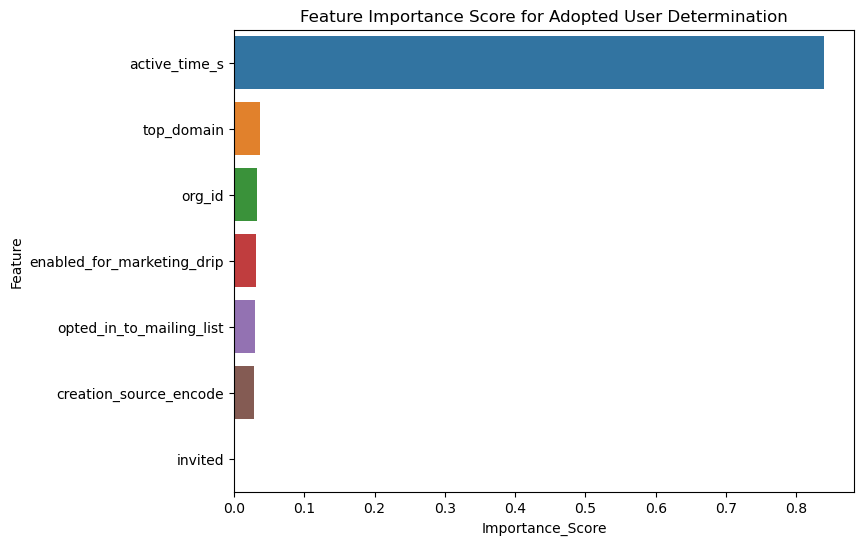

In [199]:
# let plot the scores
plt.figure(figsize = (8, 6))
sns.barplot(data = df_fi, x = 'Importance_Score', y = 'Feature')
plt.title('Feature Importance Score for Adopted User Determination')
plt.show()

**The most importance feature determing if a customer is an adopted user or not is his active time (time between last login and when the account was created).**

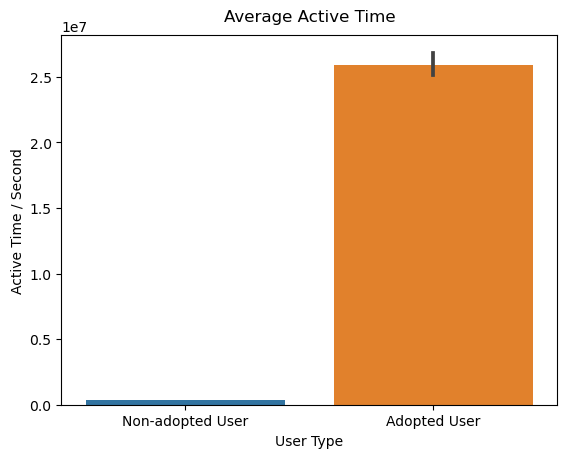

In [205]:
# let's plot the how active time different for adopted user or not
sns.barplot(data = df_user, x = 'adopted_user', y = 'active_time_s')
plt.title('Average Active Time', pad = 10)
plt.xlabel('User Type')
plt.ylabel('Active Time / Second')
plt.xticks([0, 1], ['Non-adopted User', 'Adopted User'])
plt.show()

# 5. Summary

* The most importance feature determing if a user is adopted or not is the user's active time. 
* The active time is defined as the time between the last login and when the account was created.
* Adopted user tends to have much longer active time compared to non-adopted user.
* This makes sense since adopted users are defined by login times.